In [166]:
import numpy as np
import pandas as pd
from plotnine import *
import itertools

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Farmer data

In [167]:
filepath = "/Users/Allegra/Documents/School/habitus/data/Ghana/"
farmer2017 = pd.read_excel(filepath + "2017/Farmer_2017.xlsx", engine='openpyxl')
farmer2020 = pd.read_excel(filepath + "2020/Farmer_2020.xlsx", engine='openpyxl')

# Remove columns that don't matter or can't be identified:
removables2017 = ['Status', 'If sorghum, type', "If other sorghum type, precise", "If soybean, type", "If other soybean type, precise"]
removables2020 = ['Status', 'If other specify', 'If other mention']
farmer2017 = farmer2017.drop(removables2017, axis = 1)
farmer2020 = farmer2020.drop(removables2020, axis = 1)

# Let's name these the same as the SRV data
rename2017 = ['nonunique_id', 'village_id', 'validation_status', 'accuracy', 'farmerDate', 'gender', 'age', 'years_farming', 'years_membership', 'literate', 'education_level', 'num_wives', 'wife_trades', 'wife_food_crops', 'wife_crafts', 'num_children', 'num_young_children', 'num_older_children', 'num_children_in_school', 'children_working', 'income', 'transportation', 'housing_material', 'access_electricity', 'access_drinking_water', 'access_healthcare', 'num_plots', 'total_acre', 'main_crop', 'secondary_crop', 'sorghum_acre', 'soybean_acre', 'has_bank_account', 'wants_credit', 'credit_from_coop', 'credit_from_third_party', 'credit_from_bank', 'loan_amount', 'loan_rate', 'has_bridge_loan', 'bridge_loan_amount', 'pledged_output', 'wants_standardized_credit', 'wants_standardized_credit_amount', 'input_use', 'input_cost', 'inputs_useful', 'interest_use_inputs', 'interest_insurance', 'capacity_to_pay_insurance', 'use_ag_services', 'ag_services_quality', 'ag_services_frequency', 'interest_ag_services', 'capacity_to_pay_ag_services', 'buyer_type', 'buyer_search_difficulty', 'last_price_sorghum', 'last_price_soybean', 'payment_delay', 'interest_rapid_payment', 'harvest_pickup_conditions', 'need_rapid_pickup', 'id']
rename2020 = ['nonunique_id', 'village_id', 'validation_status', 'accuracy', 'farmerDate', 'gender', 'age', 'years_farming', 'years_membership', 'literate', 'education_level', 'num_wives', 'wife_trades', 'wife_food_crops', 'wife_crafts', 'num_children', 'num_young_children', 'num_older_children', 'num_children_in_school', 'children_working', 'transportation', 'housing_material', 'access_electricity', 'access_drinking_water', 'access_healthcare', 'income', 'remittance', 'nonfarm_income', 'livestock_income', 'govt_income', 'farm_maintenance_cost', 'energy_cost', 'household_cost', 'cash_at_start_of_season', 'bank_name', 'wants_credit', 'credit_from_bank', 'credit_from_coop', 'credit_from_third_party', 'loan_amount', 'loan_rate', 'has_bridge_loan', 'bridge_loan_amount', 'pledged_output', 'wants_bridge_loan', 'wants_bridge_loan_amount', 'input_use', 'input_cost', 'inputs_useful', 'interest_use_inputs', 'interest_insurance', 'capacity_to_pay_insurance', 'use_ag_services', 'ag_services_quality', 'ag_services_frequency', 'interest_ag_services', 'capacity_to_pay_ag_services', 'buyer_type', 'buyer_search_difficulty', 'last_price_soybean', 'second_cash_crop', 'second_cash_crop_price', 'third_cash_crop', 'third_cash_crop_price', 'payment_delay','interest_rapid_payment', 'harvest_pickup_conditions', 'need_rapid_pickup', 'num_plots', 'total_ha', 'main_crop', 'secondary_crop', 'tractor', 'thresher', 'picker', 'rototiller', 'seeder', 'truck', 'motorpump', 'weeder', 'sprayer', 'harrower', 'cart', 'plough', 'rental_equipment_cost', 'id']

farmer2017.columns = rename2017
farmer2020.columns = rename2020

farmer2020.age = 2021 - (farmer2020['age'].astype(str).str[0:4]).astype(int)
farmer2020.loc[farmer2020.age > 100, 'age'] = np.nan

The Ghana data doesn't conserve farmer IDs between years, so I generated a hash ID for each farmer. While I was doing this I learned that there's no overlap between 2017 and 2020, so I won't check that here. I'm also going to combine the 2017 and 2020 data with an "origin" column to clean and explore all of it at once.

In [168]:
farmer2017['year_of_origin'] = 2017
farmer2020['year_of_origin'] = 2020
farmer = pd.concat([farmer2017, farmer2020])
farmer.head(1)

,nonunique_id,village_id,validation_status,accuracy,farmerDate,gender,age,years_farming,years_membership,literate,education_level,num_wives,wife_trades,wife_food_crops,wife_crafts,num_children,num_young_children,num_older_children,num_children_in_school,children_working,income,transportation,housing_material,access_electricity,access_drinking_water,access_healthcare,num_plots,total_acre,main_crop,secondary_crop,sorghum_acre,soybean_acre,has_bank_account,wants_credit,credit_from_coop,credit_from_third_party,credit_from_bank,loan_amount,loan_rate,has_bridge_loan,bridge_loan_amount,pledged_output,wants_standardized_credit,wants_standardized_credit_amount,input_use,input_cost,inputs_useful,interest_use_inputs,interest_insurance,capacity_to_pay_insurance,use_ag_services,ag_services_quality,ag_services_frequency,interest_ag_services,capacity_to_pay_ag_services,buyer_type,buyer_search_difficulty,last_price_sorghum,last_price_soybean,payment_delay,interest_rapid_payment,harvest_pickup_conditions,need_rapid_pickup,id,year_of_origin,remittance,nonfarm_income,livestock_income,govt_income,farm_maintenance_cost,energy_cost,household_cost,cash_at_start_of_season,bank_name,wants_bridge_loan,wants_bridge_loan_amount,second_cash_crop,second_cash_crop_price,third_cash_crop,third_cash_crop_price,total_ha,tractor,thresher,picker,rototiller,seeder,truck,motorpump,weeder,sprayer,harrower,cart,plough,rental_equipment_cost
0,73,73.0,Validated,2,2017-11-28 16:54:12,Mr,52.0,20,0,No,NaN,2,No,Yes,Yes,11,2,5,8,Only during the school holidays,0,Bicycle,Mud / clay,Not at all,Well,Average,2,12.0,Sorghum,Maize,3.0,0.0,Yes,Interested,Never,Never,NaN,0,0,50,200,No,Yes,1000.0,Sometimes,328,May be,May be,Yes,Less than GHS 200/acr,MOFA,Good,1-2 visits per semester,Yes,Between 5 and 15 Kg/acr,Market,Easy,5.0,0,Within 24 hours,Upon delivery,NaN,NaN,15636890444995739648,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First I'll clean data that have nonsensical values, deriving cutoff points from the histogram (can't transfer values automatically from Paul's notebook because Ghana units are sometimes different):

In [169]:
# Taken from Paul Cohen's data_cleaning notebook
def correct_range (df, col, minval, maxval, report=True):
    n = df[col].count()
    if report: print(f"Before cleaning, {col} count = {df[col].count()}, min = {df[col].min()}, max = {df[col].max()}")
    df[col].where((df[col]>=minval) & (df[col]<=maxval),inplace=True)
    if report: print(f"{df[col].describe()}")
    if report: print(f"Newly Nan records: {n - df[col].count()}\n")
  
# print(farmer.select_dtypes(include=[float,int]).columns.tolist())
ggplot(farmer.dropna(subset=['num_plots'])) + geom_histogram(aes('num_plots')) + theme_minimal()

correct_range(farmer,'age',18,100)
correct_range(farmer,'years_farming',0,100)
correct_range(farmer,'years_membership',0,100)
correct_range(farmer,'num_wives',0,6)
correct_range(farmer,'num_children',0,20)
correct_range(farmer,'income',0,10000)
correct_range(farmer,'total_acre',0,30)
correct_range(farmer,'total_ha', 0, 20)
correct_range(farmer,'sorghum_acre',0,10)
correct_range(farmer,'soybean_acre',0,10)
correct_range(farmer,'loan_amount',0,5000)
correct_range(farmer,'loan_rate',0,50)
correct_range(farmer,'has_bridge_loan', 0, 1000)
correct_range(farmer,'bridge_loan_amount',0,1000)
correct_range(farmer,'wants_bridge_loan_amount', 0, 3000)
correct_range(farmer,'wants_standardized_credit_amount',0,5000)
correct_range(farmer,'input_cost',0,2000)
correct_range(farmer,'last_price_sorghum', 0, 50)
correct_range(farmer,'last_price_soybean', 0, 25)
correct_range(farmer,'second_cash_crop_price', 0, 50)
correct_range(farmer,'third_cash_crop_price', 0, 400)
correct_range(farmer,'remittance', 0, 2500)
correct_range(farmer,'nonfarm_income', 0, 3000)
correct_range(farmer,'livestock_income', 0, 2000)
correct_range(farmer,'govt_income', 0, 250)
correct_range(farmer,'farm_maintenance_cost', 0, 1000)
correct_range(farmer,'energy_cost', 0, 500)
correct_range(farmer,'household_cost', 0, 1000)
correct_range(farmer,'cash_at_start_of_season', 0, 2000)
correct_range(farmer,'num_plots', 0, 10)

Before cleaning, age count = 1861, min = 0.0, max = 4555.0
count    1851.000000
mean       45.408968
std        15.273708
min        18.000000
25%        34.000000
50%        43.000000
75%        54.000000
max        99.000000
Name: age, dtype: float64
Newly Nan records: 10

Before cleaning, years_farming count = 1869, min = 0, max = 2005
count    1868.000000
mean       17.284797
std        12.453846
min         0.000000
25%         8.000000
50%        15.000000
75%        25.000000
max        80.000000
Name: years_farming, dtype: float64
Newly Nan records: 1

Before cleaning, years_membership count = 1869, min = 0, max = 2017
count    1754.000000
mean        0.208666
std         1.693184
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        43.000000
Name: years_membership, dtype: float64
Newly Nan records: 115

Before cleaning, num_wives count = 1869, min = 0, max = 13
count    1868.000000
mean        0.991435
std         0.851560
min         

Something to note: The 2017 form indicates that area should be supplied in acres, and the 2020 form indicates hectares. There are 2.47 acres to a hectare. However, the histograms of total_acre and total_ha look similar, so either one population of farmers has twice as much land as the other or one of the units is wrong. On top of that, a quick Google indicates that Ghana smallholder farmers often have less than an acre, so 10 ha seems really big. Thus, my hunch is that they're actually both in acres. On the other hand, the good news is that the values seem more sensible than the SRV data. I'll leave this for now.

I was surprised to see some very high loan rates, but another quick google indicated quite large loan rates can happen in Ghana, so I just capped at 50%.

Next I'll make some new columns and convert categorical variables of interest into numbers, using code swiped from Paul Cohen's SRV notebook:

loan_rate    False  True 
loan_amount              
False         1032     17
True           341    479


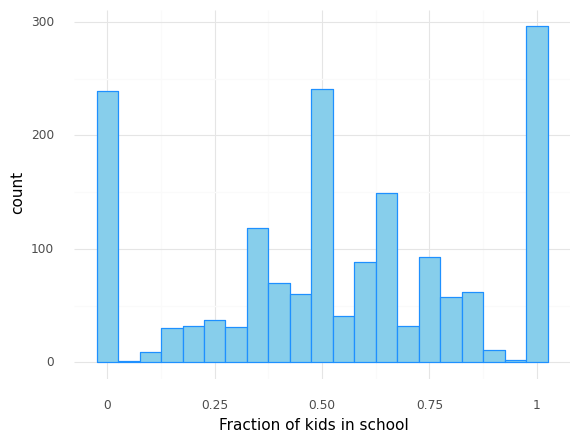

<ggplot: (295532608)>

In [170]:
print(pd.crosstab(farmer.loan_amount > 0,farmer.loan_rate > 0))

def loan_status (row):
    if row.loan_amount == 0 and row.loan_rate == 0:
        return 0
    elif row.loan_amount > 0 and row.loan_rate > 0:
        return 1
    else:
        return np.nan

farmer['has_loan'] = farmer.apply(loan_status,axis=1)
farmer['valid_children'] = farmer.num_children >= farmer.num_children_in_school
farmer['fraction_in_school'] = [s/n if (v and n > 0) else np.nan for s,n,v in zip(farmer.num_children_in_school, farmer.num_children, farmer.valid_children) ]

ggplot(farmer.dropna(subset=['fraction_in_school'])) + geom_histogram(aes(x = 'fraction_in_school'), color = 'dodgerblue', fill = 'skyblue', binwidth = 0.05) + theme_minimal() + xlab("Fraction of kids in school")


There are 341 farms that have a loan amount greater than zero but a loan rate equal to zero. This seems like a lot of farms. It's either because the agent didn't note down the loan rate or there are magical rate-free loans.

I'll recode categorical variables to match Paul's coding as best as possible next.

In [171]:
farmer.access_electricity.replace(
    to_replace={"Not at all":0, "Grid": 1, "Solar":1},inplace=True)

farmer.access_drinking_water.replace(
    to_replace={"Lake / pond":0, "River": 0, "Well": 1, "Hydraulic pump":1, "Tap":2},inplace=True)

farmer.access_healthcare.replace(
    to_replace={"Not at all":0, 'No access': 0, "Poor":0, "Average": 1, "Good":2, "Very good":2},inplace=True)

farmer.housing_material.replace(
    to_replace={"Wood":0, 'Mud':1, "Mud / clay": 1, "Bricks":2, "Concrete":2},inplace=True)

farmer.gender.replace(
    to_replace={"Mr": 0, "Ms":1, "Mrs":2},inplace=True)

farmer.wife_trades.replace(    to_replace={"No":0,"Yes":1}, inplace=True)
farmer.wife_food_crops.replace( to_replace={"No":0,"Yes":1}, inplace=True)
farmer.wife_crafts.replace(    to_replace={"No":0,"Yes":1}, inplace=True)

farmer.children_working.replace(
    to_replace = {'Never':0, 'Sometimes': 1, 'Only during the school holidays': 2, 'Only during the holidays':2,
                  'Several times a week': 3, 'Everyday': 4},
    inplace=True)


farmer.wants_credit.replace(
    to_replace= {'Not interested' : 0, 'Little interested' : 1, 'Marginally interested' : 1,
                 'Moderately interested' : 2, 'Interested' : 3, 'Very interested' : 4},
    inplace=True)

farmer.credit_from_coop.replace(
    to_replace={'Never' : 0, 'Sometimes' : 1, 'Always': 2},
    inplace=True)

farmer.credit_from_third_party.replace(
    to_replace={'Never' : 0, 'Sometimes' : 1, 'Always': 2},
    inplace=True)

farmer.credit_from_bank.replace(
    to_replace={'Never' : 0, 'Sometimes' : 1, 'Always': 2},
    inplace=True)

farmer.pledged_output.replace(
    to_replace={'No' : 0, 'In part' : 1, 'Yes': 2},
    inplace=True)

farmer.wants_bridge_loan.replace(to_replace={'No' : 0, 'Yes' : 1}, inplace=True)

farmer.interest_insurance.replace(
    to_replace={'No' : 0, 'Maybe' : 1, 'May be' : 1, 'Yes' : 2},
    inplace=True)

farmer.input_use.replace(
    to_replace={'Not at all' : 0, 'Very little' : 1, 'Seldom': 1, 'Sometimes' : 2,
                'At half of the recommended dose' : 3, 'Uses half of recommended dose' : 3, 'At recommended dose' : 4},
    inplace=True)

farmer.inputs_useful.replace(
    to_replace={'No' : 0, 'Maybe' : 1, 'May be' : 1, 'Yes' : 2},
    inplace=True)

farmer.interest_use_inputs.replace(
    to_replace={'No' : 0, 'Maybe' : 1, 'May be' : 1, 'Yes' : 2},
    inplace=True)

farmer.use_ag_services.replace(
    to_replace={'MOFA': 1, 'Presbetarisn Agric Station': 2, 'MOFA and PAS': 3, 'MoFA': 1,
       'No extenson services':0, 'Presbetarian Agric Station Garu':2,
       'No extension services':0, 'PAS':2, 'No extention services':0,
       'No extension sevices':0, 'Presbetarian Agric Station':2,
       'NO Extension services':0, 'NO extention services':0, 'MOFA PAS':3,
       'MOFAand PAS':3, 'PAS and MOFA':3, 'No extenssion':0,
       'Prebetarian Agric Station(PAS)':2, 'none':0, 'SARI':6, 'RING':6, 'No':0,
       'Agric Extension':5, 'Agric Extension Officer':5, 'nan':np.nan,
       'Agric Ectension Officer':5, 'No Agric advisories':0,
       'AgroBusiness Services':5, 'AGRA':6, 'No Agric services':0,
       'No Agric Advisories':0, 'Agriv Exrension':5, 'Agric extension':5,
       'Mofa':1, 'M0FA':1, 'Mr Sakara':6, 'Ministry of Agriculture':4,
       'Ministry of Agricultural':4, 'None':0, 'Ministry Agriculture':4,
       'Ministry Of Agriculture':4, 'Agric Ministry':4, 'Yes':np.nan, "I don't know":np.nan,
       'NO':0, 'Presbyterian Agricultural Station':2,
       'Presbyterian Agricultural Station (PAS)':2,
       'Presbyterian Agricultural station':2,
       'Presbyterian Agricultural Stations':2, 'Presbyterian Agricultural':2,
       'Presbyterian':2, 'extension services':5, 'Agric extention services':5,
       'Agric extention service':5, 'Agric extension officer':5,
       'Agric extention serviced':5,
       'Agric extension services which is rare':5,
       'Agric extension service':5, 'Agric extension services':5,
       'Agric Extension services':5, 'Extension Agric services':5,
       'Extension services':5, 'Extension service':5,
       'Agric Extension service':5, 'Agric Extension Serviced':5,
       'Agric extension serviced':5, 'Agric/vetrenary extension services':5,
       'Vertinery and agric extension services':5,
       'Vertirinery/agric extension services':5,
       'Agric extension service and veritinery':5,
       'Vertirinery and agric extension services':5, 'Good':np.nan, 'average':np.nan,
       'NIL':0, 'mofa':1, 'nill':0, 'no':0, 'No advisor':0,
       "the farmer didn't have advisor":0, "the farmer don't have advisor":0,
       'no advisor':0, 'no name':0, "don't have advisor":0, 'yes':np.nan, 'maybe':np.nan,
       'YES':np.nan, 'GOOD':np.nan, 'Average':np.nan, "don't know":np.nan, "Don't know":np.nan, 'NONE':0,
       'Not know':np.nan, "the farmer don't have agriculture advisor":0, 'Fair':np.nan,
       'Not known':np.nan, 'YED':6, 'agric extension services':5,
       'EXTENSION SERVICES':5, 'EXTENSION':5, 'EXTENTION SERVICES':5,
       'ESTENTION SERVICES':5},
    inplace=True)



farmer.ag_services_quality.replace(
    to_replace={'Not at all' : 0, 'Useless':0, 'Poor':0, 'Barely acceptable':0, 'Average' : 1, 'Good':2, 'Very good':3},
    inplace=True)

farmer.ag_services_frequency.replace(
    to_replace={
        'No visit' : 0,
        'No visit at all' : 0,
        'any visite' : 0,
        '1-2 visits per year': 1,
        '1-2 visits per semester' : 2,
        '1-2 visits per quarter' : 2,
        '1 visit per month' : 3,
        '2 visits per month' : 4},
    inplace=True)

farmer.interest_ag_services.replace(
    to_replace={'No' : 0, 'Maybe' : 1, 'May be' : 1, 'Yes' : 2},
    inplace=True)

farmer.buyer_type.replace(
    to_replace={'Market' : 'market', 'Lender': 'lender',
                'Cooperative':'coop','Itinerant buyer' : 'merchant'},
    inplace=True)

farmer.main_crop.replace(
    to_replace={'Sorghum': 'sorghum', 'Pearl Millet':'millet', 'Maize': 'maize', 'Groundnut': 'peanut', 'Soybean': 'soybean',
                'Upland rice': 'URice'},
    inplace=True)

farmer.secondary_crop.replace(
    to_replace={'Irrigated rice': 'IRice',
                'Upland rice': 'URice',
                'Cowpea:':'cowpea',
                'Maize': 'maize',
                'Soybean': 'soybean',
                'Potato': 'potato',
                'Tomato': 'tomato',
                'Sorghum':'sorghum',
                'Pearl Millet' : 'millet',
                'Groundnut': 'peanut'},
    inplace=True)

farmer.second_cash_crop.replace(
    to_replace={'Irrigated rice': 'IRice',
                'Upland rice': 'URice',
                'Cowpea:':'cowpea',
                'Maize': 'maize',
                'Soybean': 'soybean',
                'Potato': 'potato',
                'Tomato': 'tomato',
                'Sorghum':'sorghum',
                'Pearl Millet' : 'millet',
                'Groundnut': 'peanut'},
    inplace=True)

farmer.third_cash_crop.replace(
    to_replace={'Irrigated rice': 'IRice',
                'Upland rice': 'URice',
                'Cowpea:':'cowpea',
                'Maize': 'maize',
                'Soybean': 'soybean',
                'Potato': 'potato',
                'Tomato': 'tomato',
                'Sorghum':'sorghum',
                'Pearl Millet' : 'millet',
                'Groundnut': 'peanut',
                'Gardening': 'garden'},
    inplace=True)

farmer.transportation.replace(
    to_replace={'By foot': 0, 'Bicycle': 1, 'Bike': 1, 'Animal (e.g. equine)': 2, 'Motorcycle/Moped':3,'Car':4},
    inplace=True)

farmer.has_bank_account.replace(
    to_replace={'No': 0, 'Yes':1},
    inplace=True)

farmer.buyer_search_difficulty.replace(
    to_replace={'Impossible': 0, 'Very difficult': 0, 'Difficult': 0, 'Easy': 1, 'Very easy': 1},
    inplace=True)

farmer.payment_delay.replace(
    to_replace={'Within 1 month': 0, 'Maximum one week': 1, 'Within 1 week': 1, 'Within 24 hours':2, 'Within 48 hours': 2, 'Maximum 24 hours':2, 'Maximum 48 hours':2},
    inplace=True)

farmer.harvest_pickup_conditions.replace(
    to_replace={'Very unhappy': 0, 'Unhappy': 0, 'Very poor': 0, 'Poor': 0, 'Neither happy nor unhappy': 1, 'Average': 1, 'Good': 2, 'Very good':2, 'Happy': 2, "Very happy": 2},
    inplace=True)

farmer.need_rapid_pickup.replace(
    to_replace={'Not useful': 0, 'Moderately useful': 1, 'Useful': 2, 'Very useful': 2},
    inplace=True)

farmer.bank_name.replace(
    to_replace={'Other': 0, 'Agricultural Development Bank (ADB)': 1},
    inplace=True)

In [172]:
farmer.head(10)

,nonunique_id,village_id,validation_status,accuracy,farmerDate,gender,age,years_farming,years_membership,literate,education_level,num_wives,wife_trades,wife_food_crops,wife_crafts,num_children,num_young_children,num_older_children,num_children_in_school,children_working,income,transportation,housing_material,access_electricity,access_drinking_water,access_healthcare,num_plots,total_acre,main_crop,secondary_crop,sorghum_acre,soybean_acre,has_bank_account,wants_credit,credit_from_coop,credit_from_third_party,credit_from_bank,loan_amount,loan_rate,has_bridge_loan,bridge_loan_amount,pledged_output,wants_standardized_credit,wants_standardized_credit_amount,input_use,input_cost,inputs_useful,interest_use_inputs,interest_insurance,capacity_to_pay_insurance,use_ag_services,ag_services_quality,ag_services_frequency,interest_ag_services,capacity_to_pay_ag_services,buyer_type,buyer_search_difficulty,last_price_sorghum,last_price_soybean,payment_delay,interest_rapid_payment,harvest_pickup_conditions,need_rapid_pickup,id,year_of_origin,remittance,nonfarm_income,livestock_income,govt_income,farm_maintenance_cost,energy_cost,household_cost,cash_at_start_of_season,bank_name,wants_bridge_loan,wants_bridge_loan_amount,second_cash_crop,second_cash_crop_price,third_cash_crop,third_cash_crop_price,total_ha,tractor,thresher,picker,rototiller,seeder,truck,motorpump,weeder,sprayer,harrower,cart,plough,rental_equipment_cost,has_loan,valid_children,fraction_in_school
0,73,73.0,Validated,2,2017-11-28 16:54:12,0.0,52.0,20.0,0.0,No,NaN,2.0,0,1,1,11.0,2,5,8,2.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,12.0,sorghum,maize,3.0,0.0,1.0,3.0,0.0,0.0,NaN,0.0,0.0,50.0,200.0,0.0,Yes,1000.0,2.0,328.0,1.0,1.0,2.0,Less than GHS 200/acr,1.0,2.0,2.0,2.0,Between 5 and 15 Kg/acr,market,1.0,5.0,0.0,2.0,Upon delivery,NaN,NaN,15636890444995739648,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True,0.727273
1,74,73.0,Validated,2,2017-11-21 10:21:58,0.0,80.0,50.0,0.0,No,NaN,3.0,0,0,1,NaN,4,15,17,3.0,1000.0,1.0,1.0,0.0,1.0,1.0,2.0,20.0,sorghum,maize,1.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,2.0,600.0,1.0,2.0,0.0,NaN,1.0,1.0,2.0,0.0,NaN,market,1.0,5.0,0.0,2.0,Upon delivery,NaN,NaN,15644879801950879744,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN
2,75,73.0,Validated,2,2017-12-05 10:46:22,0.0,55.0,30.0,0.0,No,NaN,3.0,0,0,1,7.0,3,2,3,1.0,700.0,0.0,1.0,0.0,1.0,1.0,2.0,10.0,sorghum,maize,2.0,0.0,0.0,3.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,2.0,90.0,2.0,2.0,2.0,Between GHS 400 and 800/acr,1.0,1.0,2.0,2.0,5 Kg/acr,market,1.0,3.0,0.0,2.0,Upon delivery,2.0,2.0,13277218681933049856,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True,0.428571
3,76,73.0,Validated,2,2017-11-21 10:01:33,0.0,50.0,34.0,0.0,No,NaN,2.0,0,0,1,8.0,3,4,5,1.0,1500.0,1.0,1.0,0.0,1.0,1.0,2.0,7.0,sorghum,NaN,1.5,0.0,1.0,3.0,0.0,1.0,0.0,200.0,10.0,0.0,0.0,0.0,Yes,500.0,2.0,540.0,2.0,0.0,0.0,NaN,1.0,1.0,2.0,1.0,Between 5 and 15 Kg/acr,market,0.0,2.0,0.0,2.0,Upon delivery,NaN,NaN,13568254656802590720,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,True,0.625000
4,77,73.0,Validated,2,2017-11-27 09:23:36,0.0,60.0,40.0,0.0,No,Primary,1.0,0,0,1,2.0,0,0,0,1.0,2500.0,1.0,1.0,0.0,1.0,1.0,3.0,7.0,sorghum,maize,1.0,0.0,0.0,2.0,0.0,1.0,0.0,100.0,0.0,0.0,0.0,0.0,NaN,0.0,2.0,0.0,2.0,0.0,0.0,NaN,1.0,1.0,1.0,2.0,Between 15 and 30 kg/acr,coop,1.0,2.0,0.0,2.0,Upon delivery,NaN,NaN,17491775450337400832,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.000000
5,78,73.0,Validated,1,2017-11-20 16:31:55,2.0,40.0,25.0,0.0,No,NaN,0.0,0,0,0,5.0,2,2,5,1.0,900.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,sorghum,maize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

I'm not going to mess with binning or analysis right now because my short-term goal is to get the farmer, village and seasonal data ready for people to use. So, onwards!

In [173]:
farmer.to_csv(filepath+"demographicfarmer_GHANA_cleaned_2017_2020.csv",index=False)
farmer[farmer['year_of_origin'] == 2017].to_csv(filepath+"demographicfarmer_GHANA_cleaned_2017.csv",index=False)
farmer[farmer['year_of_origin'] == 2020].to_csv(filepath+"demographicfarmer_GHANA_cleaned_2020.csv",index=False)

### Grouping by village

We can see there's two cohorts (2017 and 2020) that come from a variety of villages:

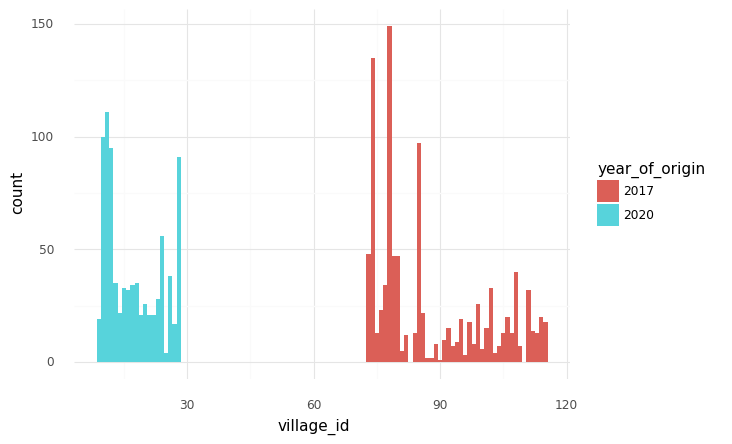

<ggplot: (292727839)>

In [174]:
farmer['year_of_origin'] = farmer['year_of_origin'].astype('category')
ggplot(farmer.dropna(subset=['village_id']))+geom_histogram(aes(x = 'village_id', fill = 'year_of_origin'), binwidth = 1) + theme_minimal()



### Village/coop data

Fortunately, the village IDs seem to be conserved across years, so no worries there. Unfortunately, we don't have specific coop/groupement names for Ghana.

In [154]:
village2017 = pd.read_excel(filepath + "2017/Village_2017.xlsx", engine='openpyxl')
village2020 = pd.read_excel(filepath + "2020/Village_2020.xlsx", engine='openpyxl')

print(village2017.head(4))
print(village2020.head(4))
# # Remove columns that don't matter or can't be identified:
# removables2017 = ['Status', 'If sorghum, type', "If other sorghum type, precise", "If soybean, type", "If other soybean type, precise"]
# removables2020 = ['Status', 'If other specify', 'If other mention']
# farmer2017 = farmer2017.drop(removables2017, axis = 1)
# farmer2020 = farmer2020.drop(removables2020, axis = 1)

# # Let's name these the same as the SRV data
# rename2017 = ['nonunique_id', 'village_id', 'validation_status', 'accuracy', 'farmerDate', 'gender', 'age', 'years_farming', 'years_membership', 'literate', 'education_level', 'num_wives', 'wife_trades', 'wife_food_crops', 'wife_crafts', 'num_children', 'num_young_children', 'num_older_children', 'num_children_in_school', 'children_working', 'income', 'transportation', 'housing_material', 'access_electricity', 'access_drinking_water', 'access_healthcare', 'num_plots', 'total_acre', 'main_crop', 'secondary_crop', 'sorghum_acre', 'soybean_acre', 'has_bank_account', 'wants_credit', 'credit_from_coop', 'credit_from_third_party', 'credit_from_bank', 'loan_amount', 'loan_rate', 'has_bridge_loan', 'bridge_loan_amount', 'pledged_output', 'wants_standardized_credit', 'wants_standardized_credit_amount', 'input_use', 'input_cost', 'inputs_useful', 'interest_use_inputs', 'interest_insurance', 'capacity_to_pay_insurance', 'use_ag_services', 'ag_services_quality', 'ag_services_frequency', 'interest_ag_services', 'capacity_to_pay_ag_services', 'buyer_type', 'buyer_search_difficulty', 'last_price_sorghum', 'last_price_soybean', 'payment_delay', 'interest_rapid_payment', 'harvest_pickup_conditions', 'need_rapid_pickup', 'id']
# rename2020 = ['nonunique_id', 'village_id', 'validation_status', 'accuracy', 'farmerDate', 'gender', 'age', 'years_farming', 'years_membership', 'literate', 'education_level', 'num_wives', 'wife_trades', 'wife_food_crops', 'wife_crafts', 'num_children', 'num_young_children', 'num_older_children', 'num_children_in_school', 'children_working', 'transportation', 'housing_material', 'access_electricity', 'access_drinking_water', 'access_healthcare', 'income', 'remittance', 'nonfarm_income', 'livestock_income', 'govt_income', 'farm_maintenance_cost', 'energy_cost', 'household_cost', 'cash_at_start_of_season', 'bank_name', 'wants_credit', 'credit_from_bank', 'credit_from_coop', 'credit_from_third_party', 'loan_amount', 'loan_rate', 'has_bridge_loan', 'bridge_loan_amount', 'pledged_output', 'wants_bridge_loan', 'wants_bridge_loan_amount', 'input_use', 'input_cost', 'inputs_useful', 'interest_use_inputs', 'interest_insurance', 'capacity_to_pay_insurance', 'use_ag_services', 'ag_services_quality', 'ag_services_frequency', 'interest_ag_services', 'capacity_to_pay_ag_services', 'buyer_type', 'buyer_search_difficulty', 'last_price_soybean', 'second_cash_crop', 'second_cash_crop_price', 'third_cash_crop', 'third_cash_crop_price', 'payment_delay','interest_rapid_payment', 'harvest_pickup_conditions', 'need_rapid_pickup', 'num_plots', 'total_ha', 'main_crop', 'secondary_crop', 'tractor', 'thresher', 'picker', 'rototiller', 'seeder', 'truck', 'motorpump', 'weeder', 'sprayer', 'harrower', 'cart', 'plough', 'rental_equipment_cost', 'id']

# farmer2017.columns = rename2017
# farmer2020.columns = rename2020

,ID,Parent ID,Object state,Status,Title,Subtitle,Lon,Lat,Precision,Date,Region,District name,Village name,Village centroid,Village total area,Village soybean area,Accessibility,Tigo network quality,AIRTEL network quality,Vodafone network quality,MTN network quality,Rain gauge in the village,"If yes, type",Soybean Growers Nb. (total),Of which women,Maize,Soybean,Groundnut,Upland rice,Irrigated rice,Pearl millet,Sesame,Fruit trees,Gardening,Sorghum,Cowpea,Tomato,Potato,Cassava,Livestock rearing,Other,Access to inputs,Access to credit,Access to agric. advisories,Population,Households,Men,Women,Children,Access to electricity,Access to water,Distance to water point,Sanitation,Distance to functional school,Distance to health center,Distance to retail shop
0,9,NaN,Validated,Enable,Savelugu - Tindan,Northern,-0.916603,9.667677,2,2020-03-29 11:14:30,Northern,Savelugu,Tindan,-0.91658 | 9.6677333333333,50,35,Fair,Poor,Average,Fair,Good,No,NaN,75,10,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,Yes,Yes,No,Yes,No,Fair,Poor,Fair,1056,60,400,500,156,Grid - permanent,"Running stream (river, ...)",100 - 200 m,Open-air,100 - 200 m,> 3 Km,NaN
1,10,NaN,Validated,Enable,Mion - Chegu,Northern,-0.428300,9.345638,3,2020-03-25 11:48:07,Northern,Mion,Chegu,-0.42834 | 9.345485,860,450,Fair,Fair,Fair,Fair,Fair,No,NaN,440,230,Yes,Yes,Yes,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Fair,Poor,Poor,1250,97,460,557,233,No electricity,"Running stream (river, ...)",200 - 500 m,Open-air,100 - 200 m,1 - 3 Km,1 - 3 Km
2,11,NaN,Validated,Enable,Garu - kpatua,upper East,-0.238553,10.716397,2,2020-04-01 20:02:39,upper East,Garu,kpatua,-0.23859 | 10.716366666667,120,45,Good,Fair,Good,Fair,Good,No,NaN,34,11,Yes,Yes,Yes,No,No,No,No,No,No,Yes,No,No,No,No,Yes,No,Fair,Poor,Poor,190,31,78,52,60,No electricity,Well,200 - 500 m,Individual toilet,500 - 1 Km,1 - 3 Km,1 - 3 Km
3,12,NaN,Validated,Enable,Garu - kpatua,upper east,-0.238535,10.716390,2,2020-04-06 09:59:25,upper east,Garu,kpatua,-0.23855666666667 | 10.71638,45,120,Good,Fair,Good,Fair,Good,No,NaN,34,11,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Fair,Poor,Poor,190,31,78,52,60,No electricity,Well,1 - 3 Km,Individual toilet,500 - 1 Km,1 - 3 Km,1 - 3 Km


### Seasonal data